In [44]:
from sklearn import ensemble, neighbors, svm, linear_model, model_selection, tree, metrics, preprocessing
from sklearn.cluster import KMeans
from itertools import product
import streamlit as st
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt


In [45]:
def get_chart(data):
    hover = alt.selection_single(
        fields=["timestamp"],
        nearest=True,
        on="mouseover",
        empty="none",
    )

    lines = (
        alt.Chart(data.reset_index(drop=True).melt("timestamp"),
                  title="Metrics variation")
        .mark_line()
        .encode(
            x="timestamp:T",
            y="value:Q",
            color="variable",
            # strokeDash="variable",
        ).properties(width=800, height=400)
    )

    # Draw points on the line, and highlight based on selection
    points = lines.transform_filter(hover).mark_circle(size=65)

    # Draw a rule at the location of the selection
    tooltips = (
        alt.Chart(data.reset_index(drop=True).melt("timestamp"),
                  title="Metrics variation")
        .mark_rule()
        .encode(
            x="timestamp:T",
            y="value:Q",
            opacity=alt.condition(hover, alt.value(0.3), alt.value(0)),
            tooltip=[
                alt.Tooltip("timestamp", title="Time"),
                alt.Tooltip("value", title="Metrics"),
            ],
        )
        .add_selection(hover)
    )

    return (lines + points + tooltips).interactive()

In [46]:
def get_stress_chart(data, symbol):
    hover = alt.selection_single(
        fields=["stress"],
        nearest=True,
        on="mouseover",
        empty="none",
    )

    lines = (
        alt.Chart(data, title="Qos variation with stress " + symbol)
        .mark_line()
        .encode(
            x=alt.X("stress:Q", axis=alt.Axis(orient="top")),
            y=alt.Y("degradation-percent:Q", sort='descending',
                    title="degradation percent(%)"),
            color="type",
            strokeDash="type",
        )
    )

    # Draw points on the line, and highlight based on selection
    points = lines.transform_filter(hover).mark_circle(size=65)

    # Draw a rule at the location of the selection
    tooltips = (
        alt.Chart(data)
        .mark_rule()
        .encode(
            x="stress:Q",
            y="degradation-percent:Q",
            opacity=alt.condition(hover, alt.value(0.3), alt.value(0)),
            tooltip=[
                alt.Tooltip("stress", title="Stress Info"),
                alt.Tooltip("avg-qos", title="Qos"),
                alt.Tooltip("degradation-percent", title="Degradation Percent")
            ],
        )
        .add_selection(hover)
    )

    return (lines + points + tooltips).interactive()

In [47]:
def stress_sensitivity(stress_degrade):
    if stress_degrade['degradation-percent'] <= 5:
        return "no"

    if stress_degrade['degradation-percent'] <= 10:
        return "low"

    if stress_degrade['degradation-percent'] <= 20:
        return "medium"

    return "high"

In [48]:
def get_usage_chart(data, symbol):
    hover = alt.selection_single(
        fields=["stress"],
        nearest=True,
        on="mouseover",
        empty="none",
    )

    lines = (
        alt.Chart(data, title="CPU usage variation with stress " + symbol)
        .mark_line()
        .encode(
            x=alt.X("stress:Q", axis=alt.Axis(orient="top")),
            y=alt.Y("avg-cpu-usage:Q", sort='descending',
                    title="cpu usage percent(%)"),
            color="type",
            strokeDash="type",
        )
    )

    # Draw points on the line, and highlight based on selection
    points = lines.transform_filter(hover).mark_circle(size=65)

    # Draw a rule at the location of the selection
    tooltips = (
        alt.Chart(data)
        .mark_rule()
        .encode(
            x="stress:Q",
            y="avg-cpu-usage:Q",
            opacity=alt.condition(hover, alt.value(0.3), alt.value(0)),
            tooltip=[
                alt.Tooltip("stress", title="Stress Info"),
                alt.Tooltip("avg-cpu-usage", title="CPU Usage Percent")
            ],
        )
        .add_selection(hover)
    )

    return (lines + points + tooltips).interactive()

In [49]:
def normalize_table(df):
    cols = list(df)
    for item in cols:
        if df[item].dtype == 'int64' or df[item].dtype == 'float64':
            max_tmp = np.max(np.array(df[item]))
            min_tmp = np.min(np.array(df[item]))
            if (max_tmp != min_tmp):
                df[item] = df[item].apply(
                    lambda x: (x - min_tmp) * 100 / (max_tmp - min_tmp))

In [50]:

def standardize_table(df):
    cols = list(df)
    for item in cols:
        if df[item].dtype == 'int64' or df[item].dtype == 'float64':
            mean_tmp = np.mean(np.array(df[item]))
            std_tmp = np.std(np.array(df[item]))
            if(std_tmp):
                df[item] = df[item].apply(lambda x: (x - mean_tmp) / std_tmp)

In [51]:
st.set_page_config(layout="centered", page_icon="⎈",
                   page_title="rubik analysis")

st.markdown("# ⎈ 混部干扰建模分析工具")
st.markdown("## 业务介绍 TODO")
st.markdown("## 环境说明")

node_info = pd.read_csv("../tests/data/default/node.csv", index_col="Item")
uploaded_node_file = st.file_uploader("上传测试环境配置", type="csv")
if uploaded_node_file is not None:
    node_info = pd.read_csv(uploaded_node_file, index_col="Item")

st.table(node_info)




DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

In [52]:
st.markdown("## 指标数据")
data = pd.read_csv("../tests/data/default/nginx.csv")
data_select = st.radio(
    """选择分析的数据集
    """,
    ('l3cache_stress.csv', 'nginx.csv'))
if data_select == 'l3cache_stress.csv':
    data = pd.read_csv("../tests/data/clickhouse/l3cache_stress.csv")
else:
    data=pd.read_csv("../tests/data/default/nginx.csv")
mode = st.radio(
    "Please select a mode to visualize the data:",
    ('origin', 'normalization', 'standardization'))

if mode == 'normalization':
    normalize_table(data)
elif mode == 'standardization':
    standardize_table(data)
# data = pd.read_csv("../tests/data/default/nginx.csv")
# data = pd.read_csv("../tests/data/clickhouse/l3cache_stress.csv")

In [53]:
uploaded_metrics_file = st.file_uploader("上传指标数据-QoS数据", type="csv")
if uploaded_metrics_file is not None:
    data = pd.read_csv(uploaded_metrics_file)



all_symbols = list(data.columns[1:])
symbols = st.multiselect("Choose metrics to visualize",
                         all_symbols, all_symbols[:3])
symbols.insert(0, data.columns[0])

source = data[symbols]

chart = get_chart(source)
st.altair_chart(chart, use_container_width=True)

DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

In [54]:
st.markdown("## 资源敏感度分析")

# type stress avg-qos degradation-percent
stress = pd.read_csv("../tests/data/default/stress.csv", keep_default_na=False)
uploaded_stress_file = st.file_uploader("上传压力测试指标数据", type="csv")
if uploaded_stress_file is not None:
    stress = pd.read_csv(uploaded_stress_file)

symbol_transform = {
    "icache": "cache",
    "L1 cache": "cache",
    "L2 cache": "cache",
    "L3 cache": "cache",

    "network in": "network",
    "network out": "network",
}
def get_key(dict, value):
    return [k for k,v in dict.items() if v == value]

stress_unique_symbols = stress.type.unique()
stress_symbols = []

for symbol in stress_unique_symbols:
    if symbol in symbol_transform:
        symbol = symbol_transform[symbol]

    if symbol == 'none':
        continue

    if symbol not in stress_symbols:
        stress_symbols.append(symbol)

stress_symbols = st.multiselect("Choose resource symbols",
                                stress_symbols, stress_symbols)

for stress_symbol in stress_symbols:
    # 插入无压力数据
    nstress = stress[stress.type == "none"]

    if stress_symbol in symbol_transform.values():
        keys = get_key(symbol_transform, stress_symbol)
        stress_source = stress[stress['type'].isin(keys)]
        for key in keys:
            stress_source = pd.concat([stress_source, nstress.replace(
                "none", key)], axis=0, ignore_index=True)
    else:
        stress_source = stress[stress['type'] == stress_symbol]
        stress_source = pd.concat([stress_source, nstress.replace(
                "none", stress_symbol)], axis=0, ignore_index=True)

    stress_chart = get_stress_chart(stress_source, stress_symbol)
    st.altair_chart(stress_chart, use_container_width=True)

In [55]:
st.markdown("#### 资源敏感度排序")

stress_degrade = (
    stress.drop(stress[stress['type'] == "none"].index)[
        ['type', 'degradation-percent']]
    .groupby(by='type')
    .max()
    .sort_values(by='degradation-percent', ascending=False)
)

stress_degrade.loc[:, 'sensitivity'] = stress_degrade.apply(
    stress_sensitivity, axis=1)
st.table(stress_degrade)

st.info(
    "degradation-percent in (, 5]:no ; (5, 10]:low ; (10, 20]:medinum ; (20,):high")

DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

In [56]:
st.markdown("## 资源利用率")

# type stress avg-qos degradation-percent
usage = pd.read_csv("../tests/data/default/machine.csv", keep_default_na=False)
uploaded_usage_file = st.file_uploader("上传利用率数据", type="csv")
if uploaded_usage_file is not None:
    usage = pd.read_csv(uploaded_usage_file)

usage_unique_symbols = usage.type.unique()
usage_symbols = []

for symbol in usage_unique_symbols:
    if symbol in symbol_transform:
        symbol = symbol_transform[symbol]

    if symbol == 'none':
        continue

    if symbol not in usage_symbols:
        usage_symbols.append(symbol)

usage_symbols = st.multiselect("Choose resource symbols to display",
                                usage_symbols, usage_symbols)

for usage_symbol in usage_symbols:
    # 插入无压力数据
    nusage = usage[usage['type'] == "none"]

    if usage_symbol in symbol_transform.values():
        keys = get_key(symbol_transform, usage_symbol)
        usage_source = usage[usage['type'].isin(keys)]
        for key in keys:
            usage_source = pd.concat([usage_source, nusage.replace(
                "none", key)], axis=0, ignore_index=True)
    else:
        usage_source = usage[usage['type'] == usage_symbol]
        usage_source = pd.concat([usage_source, nusage.replace(
                "none", usage_symbol)], axis=0, ignore_index=True)

    usage_chart = get_usage_chart(usage_source, usage_symbol)
    st.altair_chart(usage_chart, use_container_width=True)

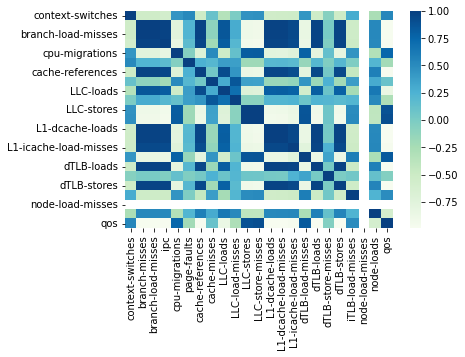

In [57]:
st.markdown("## 相关性分析")
st.markdown("### 热力图")
# pearson相关系数:  连续、正态分布、线性数据
# spearman相关系数: 非线性的、非正态数据
# Kendall相关系数:  分类变量、无序数据
fig, ax = plt.subplots()
corr_mode = st.radio(
    """选择相关性分析方法:
    pearson: 连续、正态分布、线性数据;
    spearman: 非线性的、非正态数据;
    kendall: 分类变量、无序数据""",
    ('pearson', 'spearman', 'Kendall'))

if corr_mode == 'spearman':
    metrics_correlation = data.corr(method="spearman")
elif corr_mode == 'Kendall':
    metrics_correlation = data.corr(method="kendall")
else:
    metrics_correlation = data.corr(method="pearson")

sns.heatmap(metrics_correlation, ax=ax,cmap="GnBu")
st.write(fig)

# fig = sns.pairplot(data)
# st.pyplot(fig)

st.info("|r|>0.95存在显著性相关;|r|≥0.8高度相关;0.5≤|r|<0.8 中度相关;0.3≤|r|<0.5低度相关;|r|<0.3关系极弱")
st.markdown("### 相关性指标排序")
sorted_metrics_correlation = abs(metrics_correlation.iloc[-1]).sort_values(
    ascending=False).dropna(axis=0, how='any')
st.table(sorted_metrics_correlation)

vaild_metrics = sorted_metrics_correlation[abs(
    metrics_correlation["qos"]) > 0.3].index.tolist()
vaild_metrics.remove("qos")


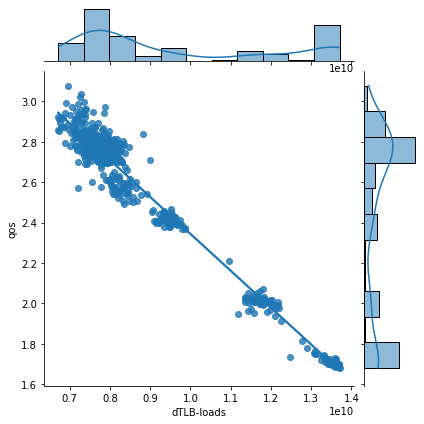

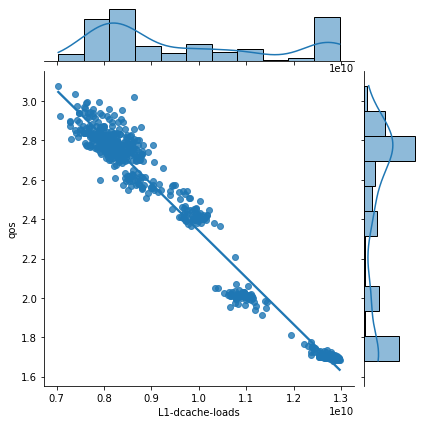

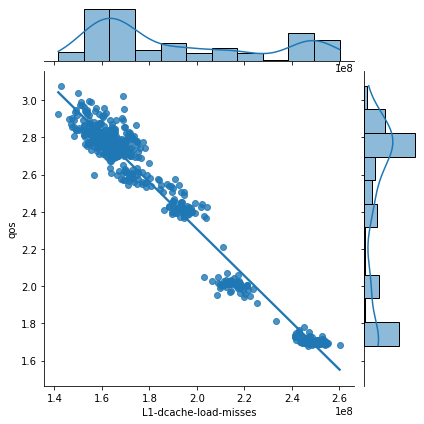

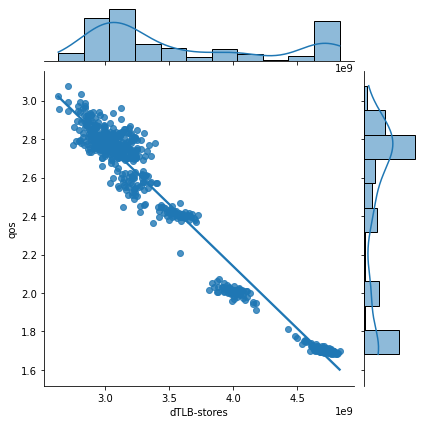

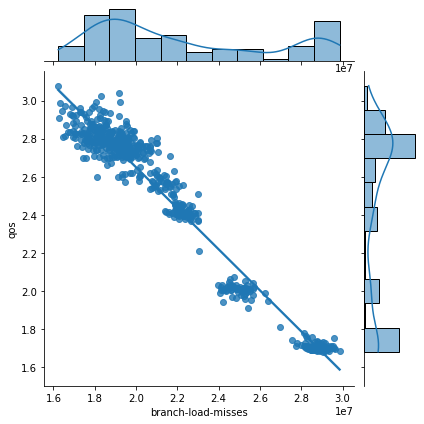

In [58]:
st.markdown("#### 筛选有效指标")
if len(vaild_metrics) == 0:
    st.markdown("        ** 指标相关性过低，无法分析** ")

vaild_metrics = vaild_metrics[:5]
vaild_metrics_cols = st.columns(len(vaild_metrics))

for col in range(len(vaild_metrics)):
    corr_value = "{:.5}".format(
        metrics_correlation.iloc[-1][vaild_metrics[col]])
    vaild_metrics_cols[col].metric(vaild_metrics[col], corr_value, col + 1)

for i in range(len(vaild_metrics)):
    fig = sns.jointplot(x=vaild_metrics[i], y='qos', data=data, kind='reg')
    st.pyplot(fig)

st.markdown("### 回归拟合分析")
# 数据预处理: 去除无效值; 特性缩放:标准化; 模型训练
x = data[vaild_metrics]
y = data[["qos"]]
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, random_state=1)

def draw_comparison_altair_chart(y_test, y_pred):
    y_test_list = y_test["qos"]
    y_pred_list = y_pred if type(y_pred[0]) is not np.ndarray else [
        i[0] for i in y_pred]
    list_of_tuples = list(zip(y_test_list, y_pred_list))
    source = pd.DataFrame(list_of_tuples, columns=['Measured', 'Predicted'],
                          index=pd.RangeIndex(len(y_pred), name='index'))
    source = source.reset_index().melt('index', var_name='category', value_name='qos')
    nearest = alt.selection(type='single', nearest=True, on='mouseover',
                            fields=['index'], empty='none')
    line = alt.Chart(source).mark_line(interpolate='basis').encode(
        x='index:Q',
        y='qos:Q',
        color='category:N'
    )

    selectors = alt.Chart(source).mark_point().encode(
        x='index:Q',
        opacity=alt.value(0),
    ).add_selection(
        nearest
    )

    points = line.mark_point().encode(
        opacity=alt.condition(nearest, alt.value(1), alt.value(0))
    )

    # Draw text labels near the points, and highlight based on selection
    text = line.mark_text(align='left', dx=5, dy=-5).encode(
        text=alt.condition(nearest, 'qos:Q', alt.value(' '))
    )

    # Draw a rule at the location of the selection
    rules = alt.Chart(source).mark_rule(color='gray').encode(
        x='index:Q',
    ).transform_filter(
        nearest
    )

    charts = alt.layer(
        line, selectors, points, rules, text
    ).interactive()
    st.altair_chart(charts, use_container_width=True)



In [59]:
def draw_comparison_matplotlib_chart(y_test, y_pred):
    fig = plt.figure()
    plt.plot(np.arange(len(y_pred)),
             y_test[["qos"]].values, 'go-', label='Measured')
    plt.plot(np.arange(len(y_pred)), y_pred, 'ro-', label='Predicted')
    plt.title("Interference Model Analysis")
    plt.xlabel("Index")
    plt.ylabel("QoS")
    plt.legend()
    st.pyplot(fig)


class RegressionModel():
    """regression model for metrics"""

    def __init__(self, model) -> None:
        self.model = model

        self.mse = 0
        self.rmse = 0

    def train_and_test_model(self):
        self.model.fit(x_train, np.ravel(y_train))

        y_pred = self.model.predict(x_test)
        # score = model.score(x_test, y_test)
        draw_comparison_altair_chart(y_test, y_pred)

        self.mse = metrics.mean_squared_error(y_test, y_pred)
        self.rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
        model_evaluation = "MSE: {}, RMSE: {}".format(self.mse, self.rmse)
        st.write(model_evaluation)


In [60]:
class PolynomialRegressionModel():
    """polynomial regression model for metrics"""

    def __init__(self, degree) -> None:
        self.model = linear_model.LinearRegression()

        self.mse = 0
        self.rmse = 0
        self.degree = degree

    def train_and_test_model(self):
        self.poly = preprocessing.PolynomialFeatures(degree = self.degree) 
        X_poly = self.poly.fit_transform(x_train)

        self.model.fit(X_poly, y_train)

        y_pred = self.model.predict(self.poly.transform(x_test))
        # score = model.score(x_test, y_test)
        draw_comparison_altair_chart(y_test, y_pred)

        self.mse = metrics.mean_squared_error(y_test, y_pred)
        self.rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
        model_evaluation = "MSE: {}, RMSE: {}".format(self.mse, self.rmse)
        st.write(model_evaluation)


In [61]:
polynomial_regression_list = [
    {'name': '1st Degree Polynomial Regression', 'degree': 1},
    {'name': '2nd Degree Polynomial Regression', 'degree': 2},
    {'name': '3rd Degree Polynomial Regression', 'degree': 3},
    {'name': '4th Degree Polynomial Regression', 'degree': 4},
    {'name': '5th Degree Polynomial Regression', 'degree': 5},
]

other_regression_list = [
    {'name': 'Decision Tree Regression', 'regressor': tree.DecisionTreeRegressor()},
    {'name': 'SVM Regression', 'regressor': svm.SVR()},
    {'name': 'KNN Regression', 'regressor': neighbors.KNeighborsRegressor()},
    {'name': 'Random Forest Regression', 'regressor': ensemble.RandomForestRegressor(n_estimators=20)},
    {'name': 'Adaboost Regression', 'regressor': ensemble.AdaBoostRegressor(n_estimators=50)},
    {'name': 'Gradient Boosting Regression', 'regressor': ensemble.GradientBoostingRegressor(n_estimators=100)},
    {'name': 'Bagging Regression', 'regressor': ensemble.BaggingRegressor()},
    {'name': 'ExtraTree Regression', 'regressor': tree.ExtraTreeRegressor()},
    {'name': 'ElasticNet','regressor':linear_model.ElasticNet()},
]

mse_list = []
polynomial_list = []

In [62]:

for polynomial_regression in polynomial_regression_list:
    st.markdown("#### " + polynomial_regression['name'])
    degree = polynomial_regression['degree']
    
    regression_model = PolynomialRegressionModel(degree)
    regression_model.train_and_test_model()

    polynomial_list.append({'name': polynomial_regression['name'], 'rmse': regression_model.rmse, 'regression_model': regression_model})
    mse_list.append({'name': polynomial_regression['name'], 'mse': regression_model.mse, 'rmse': regression_model.rmse})

for other_regression in other_regression_list:
    st.markdown("#### " + other_regression['name'])
    regressor = other_regression['regressor']
    
    regression_model = RegressionModel(regressor)
    regression_model.train_and_test_model()

    mse_list.append({'name': other_regression['name'], 'mse': regression_model.mse, 'rmse': regression_model.rmse})

f:\anaconda3\envs\rubik\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4740358851651643, tolerance: 0.009145689418493823
  positive)


In [63]:
def takeMse(elem):
    return elem['rmse']

mse_list.sort(key=takeMse)
st.table(pd.DataFrame(mse_list).set_index('name'))

DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

In [64]:
st.markdown("聚类分析")


DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

In [65]:
st.markdown("### 多项式回归拟合筛选")

polynomial = min(polynomial_list, key=takeMse)

if polynomial['rmse'] > 15:
    st.write("指标相关性较弱，不适合进行多项式回归拟合")
else:
    st.markdown("**" + polynomial['name'] + "**")
    model_evaluation = "MSE: {}, RMSE: {}".format(polynomial['regression_model'].mse, polynomial['regression_model'].rmse)
    st.write(model_evaluation)

    coef = polynomial['regression_model'].model.coef_
    feature_names = polynomial['regression_model'].poly.get_feature_names_out(vaild_metrics)

    polynomial_df = pd.DataFrame(feature_names, columns = ['features'])
    polynomial_df['coef'] = np.ravel(coef)
    st.table(polynomial_df.style.format({'coef': "{:.10f}"}))

AttributeError: 'PolynomialFeatures' object has no attribute 'get_feature_names_out'